### Step 1

Number of words in the model: 243
Sample words: ['country', 'city', 'China', 'Iraq', 'oil', 'town', 'Canada', 'London', 'England', 'Australia']
Vector dimension: 300

DataFrame shape: (243, 4)

First 10 rows of 3D vectors:
        word         x         y         z
0    country  0.746035 -0.387968 -0.482692
1       city  0.102493  0.140383 -1.189890
2      China  0.831055 -0.129504 -0.312600
3       Iraq  0.656336 -0.177794 -0.338385
4        oil  0.658342 -0.432466 -0.621214
5       town  0.378076 -0.080446 -1.053470
6     Canada  1.191959 -0.407715 -0.741816
7     London -0.297985  0.253388 -1.151864
8    England  1.103977 -0.110083 -0.893430
9  Australia  1.049531 -0.452271 -0.835773


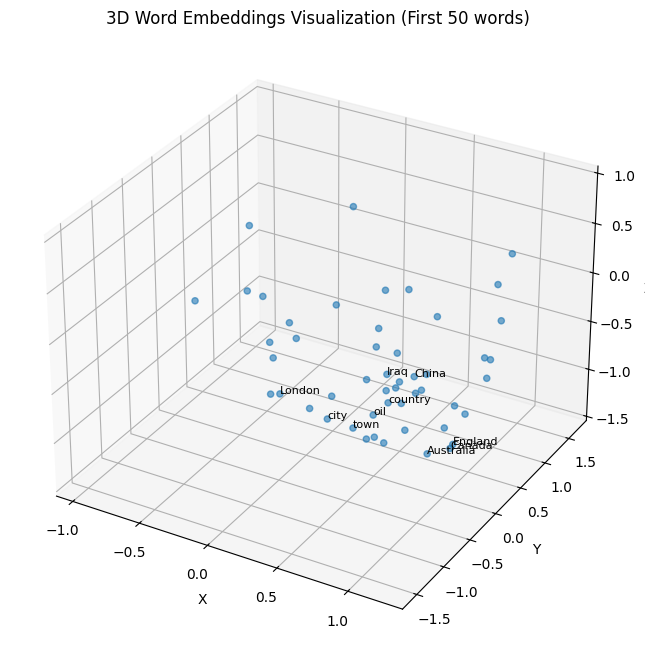

In [5]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Load the word embeddings model
def load_word_embeddings(file_path):
    """
    Load word embeddings from pickle file

    Args:
        file_path (str): Path to the pickle file containing word embeddings

    Returns:
        dict: Dictionary with words as keys and vectors as values
    """
    with open(file_path, 'rb') as f:
        word_embeddings = pickle.load(f)
    return word_embeddings

# Load the model
word_embeddings = load_word_embeddings('word_embeddings_subset.p')

print(f"Number of words in the model: {len(word_embeddings)}")
print(f"Sample words: {list(word_embeddings.keys())[:10]}")

# Check the dimension of vectors
sample_word = list(word_embeddings.keys())[0]
vector_dim = len(word_embeddings[sample_word])
print(f"Vector dimension: {vector_dim}")

# Since I need 3D vectors but the original vectors are 300D, I'll use PCA to reduce dimensionality
def create_3d_vectors(word_embeddings):
    """
    Create 3D vectors from high-dimensional word embeddings using PCA

    Args:
        word_embeddings (dict): Dictionary with word vectors

    Returns:
        pd.DataFrame: DataFrame with words and their 3D vectors
    """
    # Extract words and vectors
    words = list(word_embeddings.keys())
    vectors = np.array([word_embeddings[word] for word in words])

    # Apply PCA to reduce to 3 dimensions
    pca = PCA(n_components=3)
    vectors_3d = pca.fit_transform(vectors)

    # Create DataFrame
    df = pd.DataFrame({
        'word': words,
        'x': vectors_3d[:, 0],
        'y': vectors_3d[:, 1],
        'z': vectors_3d[:, 2]
    })

    return df, vectors_3d, pca

# Create 3D vectors DataFrame
df_3d, vectors_3d, pca_model = create_3d_vectors(word_embeddings)

print(f"\nDataFrame shape: {df_3d.shape}")
print("\nFirst 10 rows of 3D vectors:")
print(df_3d.head(10))

# Visualize some of the 3D vectors
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot first 50 words for clarity
n_words = 50
ax.scatter(df_3d['x'][:n_words], df_3d['y'][:n_words], df_3d['z'][:n_words], alpha=0.6)

# Add labels for some words
for i in range(min(10, n_words)):
    ax.text(df_3d['x'].iloc[i], df_3d['y'].iloc[i], df_3d['z'].iloc[i],
            df_3d['word'].iloc[i], fontsize=8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Word Embeddings Visualization (First 50 words)')
plt.show()

### Step 2

In [6]:
def find_closest_word_3d(target_vector, df_3d, exclude_words=None):
    """
    Find the closest word to a given 3D vector using Euclidean distance

    Args:
        target_vector (np.array): 3D vector to find closest word for
        df_3d (pd.DataFrame): DataFrame containing words and their 3D vectors
        exclude_words (list): List of words to exclude from search

    Returns:
        str: The closest word
        float: The distance to the closest word
    """
    if exclude_words is None:
        exclude_words = []

    # Filter out excluded words
    mask = ~df_3d['word'].isin(exclude_words)
    filtered_df = df_3d[mask]

    # Extract 3D vectors
    vectors = filtered_df[['x', 'y', 'z']].values

    # Calculate Euclidean distances
    distances = np.sqrt(np.sum((vectors - target_vector.reshape(1, -1))**2, axis=1))

    # Find closest word
    closest_idx = np.argmin(distances)
    closest_word = filtered_df.iloc[closest_idx]['word']
    closest_distance = distances[closest_idx]

    return closest_word, closest_distance

def get_word_vector_3d(word, df_3d):
    """
    Get 3D vector for a specific word

    Args:
        word (str): Word to get vector for
        df_3d (pd.DataFrame): DataFrame containing words and vectors

    Returns:
        np.array: 3D vector for the word
    """
    if word not in df_3d['word'].values:
        raise ValueError(f"Word '{word}' not found in the model")

    row = df_3d[df_3d['word'] == word]
    return row[['x', 'y', 'z']].values[0]

# Test the function with several examples
test_words = ['country', 'city', 'happy', 'king', 'oil']

print("Testing find_closest_word_3d function:")
print("-" * 50)

for word in test_words:
    if word in df_3d['word'].values:
        # Get the word's vector
        word_vector = get_word_vector_3d(word, df_3d)

        # Find closest word (excluding the word itself)
        closest_word, distance = find_closest_word_3d(word_vector, df_3d, exclude_words=[word])

        print(f"Word: '{word}'")
        print(f"  Closest word: '{closest_word}' (distance: {distance:.4f})")
        print()
    else:
        print(f"Word '{word}' not found in the model")

# Additional test: Find words closest to vector arithmetic results
print("\nTesting vector arithmetic:")
print("-" * 50)

# Example: king - man + woman should be close to queen (if these words exist)
if all(word in df_3d['word'].values for word in ['king', 'man', 'woman']):
    king_vec = get_word_vector_3d('king', df_3d)
    man_vec = get_word_vector_3d('man', df_3d)
    woman_vec = get_word_vector_3d('woman', df_3d)

    result_vec = king_vec - man_vec + woman_vec
    closest_word, distance = find_closest_word_3d(result_vec, df_3d)

    print("king - man + woman =", closest_word)
    print(f"Distance: {distance:.4f}")

# Test with country-capital relationships if available
if all(word in df_3d['word'].values for word in ['France', 'Paris', 'Italy']):
    france_vec = get_word_vector_3d('France', df_3d)
    paris_vec = get_word_vector_3d('Paris', df_3d)
    italy_vec = get_word_vector_3d('Italy', df_3d)

    # France - Paris + Italy should give something like Rome
    result_vec = france_vec - paris_vec + italy_vec
    closest_word, distance = find_closest_word_3d(result_vec, df_3d)

    print("\nFrance - Paris + Italy =", closest_word)
    print(f"Distance: {distance:.4f}")

Testing find_closest_word_3d function:
--------------------------------------------------
Word: 'country'
  Closest word: 'Thailand' (distance: 0.1538)

Word: 'city'
  Closest word: 'Ottawa' (distance: 0.1958)

Word: 'happy'
  Closest word: 'queen' (distance: 0.1246)

Word: 'king'
  Closest word: 'queen' (distance: 0.1026)

Word: 'oil'
  Closest word: 'country' (distance: 0.1699)


Testing vector arithmetic:
--------------------------------------------------

France - Paris + Italy = Slovenia
Distance: 1.3813


### Step 3

Available word pairs for analysis: 5
Available pairs: [('happy', 'sad'), ('king', 'queen'), ('city', 'country'), ('oil', 'gas'), ('France', 'Germany')] 
Cross Product Analysis

Pair: 'happy' × 'sad'
  Vector 1 magnitude: 1.1870
  Vector 2 magnitude: 1.1613
  Cross product magnitude: 0.2397
  Cross product vector: [-0.2074, -0.0623, -0.1028]
  Closest word to cross product: 'Nuuk' (distance: 0.3786)
  Dot product (orthogonality check): 1.3574

Pair: 'king' × 'queen'
  Vector 1 magnitude: 1.2909
  Vector 2 magnitude: 1.2499
  Cross product magnitude: 0.1194
  Cross product vector: [0.1042, 0.0085, 0.0577]
  Closest word to cross product: 'Qatar' (distance: 0.5313)
  Dot product (orthogonality check): 1.6091

Pair: 'city' × 'country'
  Vector 1 magnitude: 1.2025
  Vector 2 magnitude: 0.9696
  Cross product magnitude: 1.0019
  Cross product vector: [-0.5294, -0.8382, -0.1445]
  Closest word to cross product: 'Belmopan' (distance: 0.6118)
  Dot product (orthogonality check): 0.5963

Pair: '

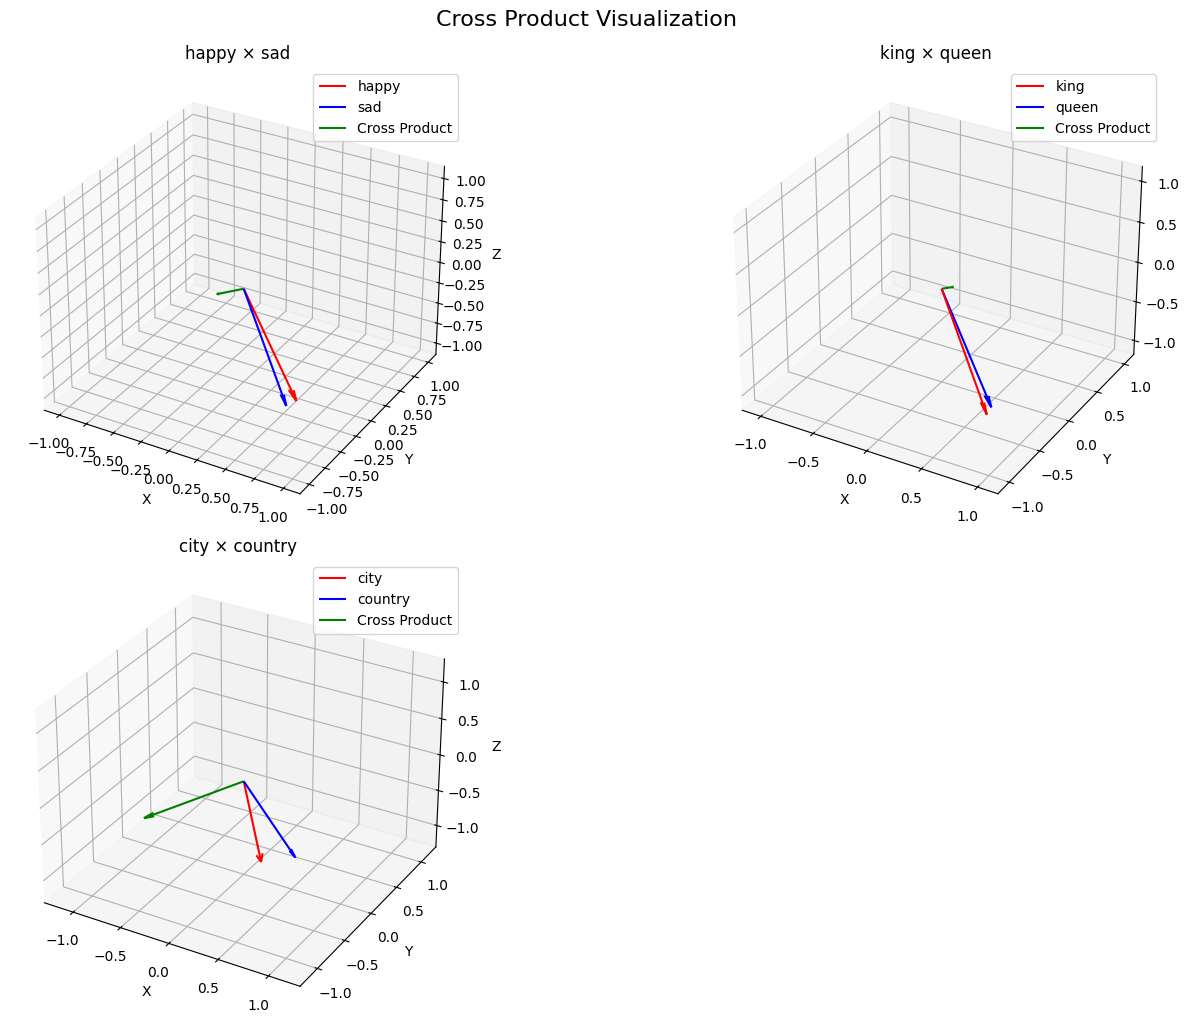

In [7]:
def calculate_cross_product(word1, word2, df_3d):
    """
    Calculate cross product of two word vectors

    Args:
        word1 (str): First word
        word2 (str): Second word
        df_3d (pd.DataFrame): DataFrame containing words and vectors

    Returns:
        np.array: Cross product vector
        str: Interpretation of the result
    """
    # Get vectors for both words
    vec1 = get_word_vector_3d(word1, df_3d)
    vec2 = get_word_vector_3d(word2, df_3d)

    # Calculate cross product
    cross_product = np.cross(vec1, vec2)

    return cross_product

def analyze_cross_product_pairs(word_pairs, df_3d):
    """
    Analyze cross products for multiple word pairs

    Args:
        word_pairs (list): List of word pairs (tuples)
        df_3d (pd.DataFrame): DataFrame containing words and vectors
    """
    print("Cross Product Analysis")
    print("=" * 60)

    for word1, word2 in word_pairs:
        if word1 in df_3d['word'].values and word2 in df_3d['word'].values:
            # Calculate cross product
            cross_product = calculate_cross_product(word1, word2, df_3d)

            # Find closest word to cross product
            closest_word, distance = find_closest_word_3d(cross_product, df_3d)

            # Calculate magnitudes for reference
            vec1 = get_word_vector_3d(word1, df_3d)
            vec2 = get_word_vector_3d(word2, df_3d)
            mag1 = np.linalg.norm(vec1)
            mag2 = np.linalg.norm(vec2)
            cross_mag = np.linalg.norm(cross_product)

            print(f"\nPair: '{word1}' × '{word2}'")
            print(f"  Vector 1 magnitude: {mag1:.4f}")
            print(f"  Vector 2 magnitude: {mag2:.4f}")
            print(f"  Cross product magnitude: {cross_mag:.4f}")
            print(f"  Cross product vector: [{cross_product[0]:.4f}, {cross_product[1]:.4f}, {cross_product[2]:.4f}]")
            print(f"  Closest word to cross product: '{closest_word}' (distance: {distance:.4f})")

            # Check if vectors are orthogonal (dot product close to 0)
            dot_product = np.dot(vec1, vec2)
            print(f"  Dot product (orthogonality check): {dot_product:.4f}")

            if abs(dot_product) < 0.1:
                print("  → Vectors are approximately orthogonal!")

        else:
            missing_words = [word for word in [word1, word2] if word not in df_3d['word'].values]
            print(f"\nSkipping pair '{word1}' × '{word2}': Missing words {missing_words}")

# Define word pairs for cross product analysis
word_pairs = [
    ('happy', 'sad'),
    ('king', 'queen'),
    ('man', 'woman'),
    ('city', 'country'),
    ('oil', 'gas'),
    ('France', 'Germany'),
    ('hot', 'cold'),
    ('big', 'small'),
    ('good', 'bad'),
    ('north', 'south')
]

# Filter pairs to only include words that exist in our model
available_pairs = []
for word1, word2 in word_pairs:
    if word1 in df_3d['word'].values and word2 in df_3d['word'].values:
        available_pairs.append((word1, word2))

print(f"Available word pairs for analysis: {len(available_pairs)}")
print("Available pairs:", available_pairs[:5], "..." if len(available_pairs) > 5 else "")

# Perform cross product analysis
analyze_cross_product_pairs(available_pairs, df_3d)

# Visualize some cross products
if len(available_pairs) >= 3:
    fig = plt.figure(figsize=(15, 10))

    for i, (word1, word2) in enumerate(available_pairs[:3]):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')

        # Get vectors
        vec1 = get_word_vector_3d(word1, df_3d)
        vec2 = get_word_vector_3d(word2, df_3d)
        cross_product = calculate_cross_product(word1, word2, df_3d)

        # Plot vectors
        ax.quiver(0, 0, 0, vec1[0], vec1[1], vec1[2],
                 color='red', arrow_length_ratio=0.1, label=word1)
        ax.quiver(0, 0, 0, vec2[0], vec2[1], vec2[2],
                 color='blue', arrow_length_ratio=0.1, label=word2)
        ax.quiver(0, 0, 0, cross_product[0], cross_product[1], cross_product[2],
                 color='green', arrow_length_ratio=0.1, label='Cross Product')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'{word1} × {word2}')
        ax.legend()

        # Set equal aspect ratio
        max_range = max(np.abs([vec1, vec2, cross_product]).max() * 1.1, 0.1)
        ax.set_xlim([-max_range, max_range])
        ax.set_ylim([-max_range, max_range])
        ax.set_zlim([-max_range, max_range])

    plt.tight_layout()
    plt.suptitle('Cross Product Visualization', y=1.02, fontsize=16)
    plt.show()

### Step 4

Analyzing 7 word pairs...
Word Relationship Analysis Using Angles

'happy' ↔ 'joyful' (Expected: very similar)
  Angle: 6.53°
  Cosine similarity: 0.9935
  Interpretation: Very similar/related
  ✓ Matches expectation!

'happy' ↔ 'sad' (Expected: opposite)
  Angle: 10.01°
  Cosine similarity: 0.9848
  Interpretation: Very similar/related
  ⚠ Different from expectation

'king' ↔ 'queen' (Expected: similar)
  Angle: 4.24°
  Cosine similarity: 0.9973
  Interpretation: Very similar/related
  ✓ Matches expectation!

'city' ↔ 'town' (Expected: similar)
  Angle: 18.33°
  Cosine similarity: 0.9493
  Interpretation: Very similar/related
  ✓ Matches expectation!

'oil' ↔ 'petroleum' (Expected: very similar)
  Angle: 12.28°
  Cosine similarity: 0.9771
  Interpretation: Very similar/related
  ✓ Matches expectation!

'oil' ↔ 'gas' (Expected: related)
  Angle: 33.20°
  Cosine similarity: 0.8368
  Interpretation: Moderately similar
  ⚠ Different from expectation

'France' ↔ 'Paris' (Expected: related)

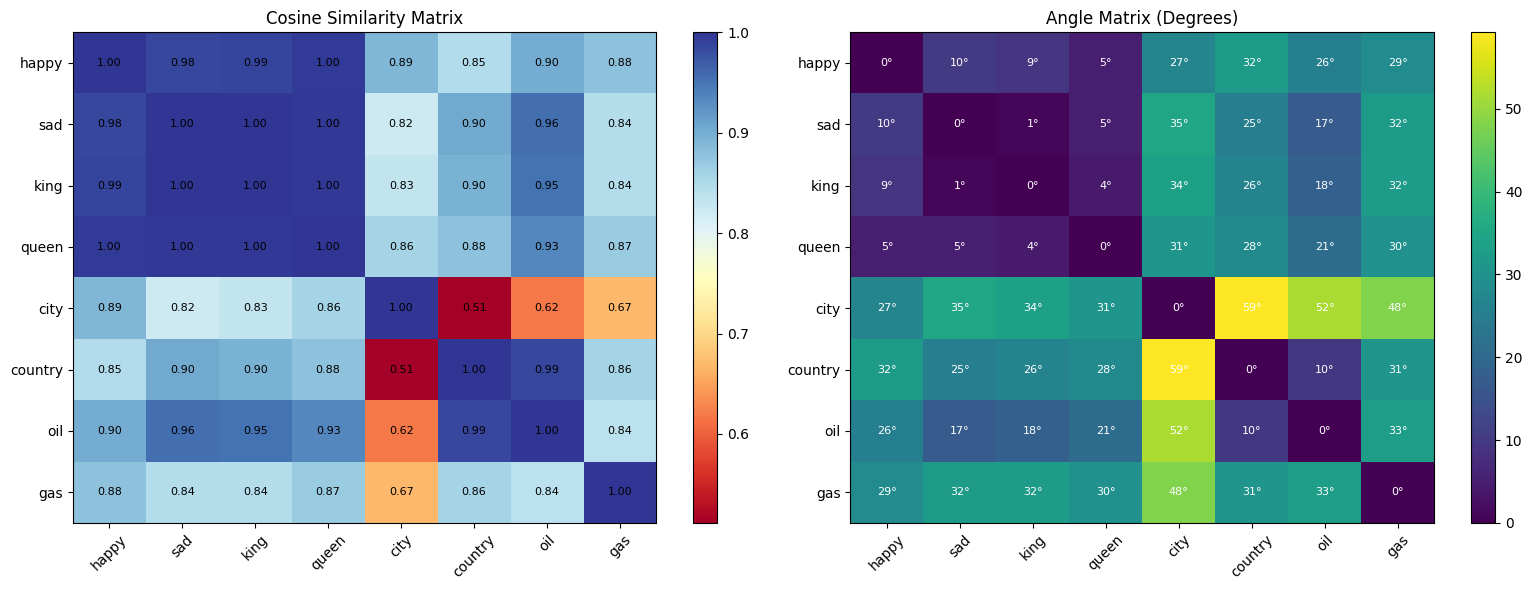



Summary Statistics:
Average angle between word pairs: 26.32°
Standard deviation of angles: 31.23°
Average cosine similarity: 0.7960
Range of angles: 4.24° to 99.62°


In [8]:
def calculate_angle_between_words(word1, word2, df_3d, return_radians=False):
    """
    Calculate the angle between two word vectors

    Args:
        word1 (str): First word
        word2 (str): Second word
        df_3d (pd.DataFrame): DataFrame containing words and vectors
        return_radians (bool): If True, return angle in radians, else in degrees

    Returns:
        float: Angle between the vectors
        str: Interpretation of the relationship
    """
    # Get vectors for both words
    vec1 = get_word_vector_3d(word1, df_3d)
    vec2 = get_word_vector_3d(word2, df_3d)

    # Calculate dot product and magnitudes
    dot_product = np.dot(vec1, vec2)
    magnitude1 = np.linalg.norm(vec1)
    magnitude2 = np.linalg.norm(vec2)

    # Calculate cosine of angle
    cos_angle = dot_product / (magnitude1 * magnitude2)

    # Handle numerical errors (cos should be between -1 and 1)
    cos_angle = np.clip(cos_angle, -1.0, 1.0)

    # Calculate angle
    angle_rad = np.arccos(cos_angle)
    angle_deg = np.degrees(angle_rad)

    # Interpret the relationship
    if angle_deg < 30:
        interpretation = "Very similar/related"
    elif angle_deg < 60:
        interpretation = "Moderately similar"
    elif angle_deg < 90:
        interpretation = "Somewhat related"
    elif angle_deg < 120:
        interpretation = "Somewhat different"
    elif angle_deg < 150:
        interpretation = "Quite different"
    else:
        interpretation = "Very different/opposite"

    return (angle_rad if return_radians else angle_deg), interpretation

def analyze_word_relationships(word_pairs, df_3d):
    """
    Analyze relationships between multiple word pairs using angles

    Args:
        word_pairs (list): List of word pairs with expected relationships
        df_3d (pd.DataFrame): DataFrame containing words and vectors
    """
    print("Word Relationship Analysis Using Angles")
    print("=" * 70)

    results = []

    for word1, word2, expected_relation in word_pairs:
        if word1 in df_3d['word'].values and word2 in df_3d['word'].values:
            angle_deg, interpretation = calculate_angle_between_words(word1, word2, df_3d)

            # Calculate additional metrics
            vec1 = get_word_vector_3d(word1, df_3d)
            vec2 = get_word_vector_3d(word2, df_3d)
            cosine_similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

            result = {
                'word1': word1,
                'word2': word2,
                'expected': expected_relation,
                'angle_degrees': angle_deg,
                'cosine_similarity': cosine_similarity,
                'interpretation': interpretation
            }
            results.append(result)

            print(f"\n'{word1}' ↔ '{word2}' (Expected: {expected_relation})")
            print(f"  Angle: {angle_deg:.2f}°")
            print(f"  Cosine similarity: {cosine_similarity:.4f}")
            print(f"  Interpretation: {interpretation}")

            # Check if interpretation matches expectation
            if expected_relation.lower() in interpretation.lower():
                print("  ✓ Matches expectation!")
            else:
                print("  ⚠ Different from expectation")

        else:
            missing_words = [word for word in [word1, word2] if word not in df_3d['word'].values]
            print(f"\nSkipping '{word1}' ↔ '{word2}': Missing words {missing_words}")

    return results

def create_similarity_matrix(words_list, df_3d):
    """
    Create a similarity matrix for a list of words

    Args:
        words_list (list): List of words to compare
        df_3d (pd.DataFrame): DataFrame containing words and vectors

    Returns:
        pd.DataFrame: Similarity matrix
    """
    # Filter words that exist in the model
    available_words = [word for word in words_list if word in df_3d['word'].values]

    if len(available_words) < 2:
        print("Not enough words available for similarity matrix")
        return None

    # Create similarity matrix
    n_words = len(available_words)
    similarity_matrix = np.zeros((n_words, n_words))
    angle_matrix = np.zeros((n_words, n_words))

    for i, word1 in enumerate(available_words):
        for j, word2 in enumerate(available_words):
            if i == j:
                similarity_matrix[i, j] = 1.0
                angle_matrix[i, j] = 0.0
            else:
                vec1 = get_word_vector_3d(word1, df_3d)
                vec2 = get_word_vector_3d(word2, df_3d)
                cosine_sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
                angle_deg, _ = calculate_angle_between_words(word1, word2, df_3d)

                similarity_matrix[i, j] = cosine_sim
                angle_matrix[i, j] = angle_deg

    # Create DataFrames
    sim_df = pd.DataFrame(similarity_matrix, index=available_words, columns=available_words)
    angle_df = pd.DataFrame(angle_matrix, index=available_words, columns=available_words)

    return sim_df, angle_df

# Define word pairs with expected relationships
relationship_pairs = [
    ('happy', 'joyful', 'very similar'),
    ('happy', 'sad', 'opposite'),
    ('king', 'queen', 'similar'),
    ('man', 'woman', 'related'),
    ('city', 'town', 'similar'),
    ('country', 'nation', 'very similar'),
    ('oil', 'petroleum', 'very similar'),
    ('oil', 'gas', 'related'),
    ('France', 'Paris', 'related'),
    ('hot', 'cold', 'opposite'),
    ('big', 'large', 'very similar'),
    ('good', 'bad', 'opposite')
]

# Filter pairs to only include available words
available_relationship_pairs = []
for word1, word2, relation in relationship_pairs:
    if word1 in df_3d['word'].values and word2 in df_3d['word'].values:
        available_relationship_pairs.append((word1, word2, relation))

print(f"Analyzing {len(available_relationship_pairs)} word pairs...")

# Perform relationship analysis
results = analyze_word_relationships(available_relationship_pairs, df_3d)

# Create similarity matrix for a subset of words
interesting_words = ['happy', 'sad', 'king', 'queen', 'man', 'woman', 'city', 'country', 'oil', 'gas']
sim_matrix, angle_matrix = create_similarity_matrix(interesting_words, df_3d)

if sim_matrix is not None:
    print(f"\n\nSimilarity Matrix (Cosine Similarity):")
    print("=" * 50)
    print(sim_matrix.round(3))

    print(f"\n\nAngle Matrix (Degrees):")
    print("=" * 30)
    print(angle_matrix.round(1))

    # Visualize similarity matrix
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Cosine similarity heatmap
    im1 = ax1.imshow(sim_matrix.values, cmap='RdYlBu', aspect='auto')
    ax1.set_xticks(range(len(sim_matrix.columns)))
    ax1.set_yticks(range(len(sim_matrix.index)))
    ax1.set_xticklabels(sim_matrix.columns, rotation=45)
    ax1.set_yticklabels(sim_matrix.index)
    ax1.set_title('Cosine Similarity Matrix')
    plt.colorbar(im1, ax=ax1)

    # Add text annotations
    for i in range(len(sim_matrix.index)):
        for j in range(len(sim_matrix.columns)):
            text = ax1.text(j, i, f'{sim_matrix.iloc[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=8)

    # Angle heatmap
    im2 = ax2.imshow(angle_matrix.values, cmap='viridis', aspect='auto')
    ax2.set_xticks(range(len(angle_matrix.columns)))
    ax2.set_yticks(range(len(angle_matrix.index)))
    ax2.set_xticklabels(angle_matrix.columns, rotation=45)
    ax2.set_yticklabels(angle_matrix.index)
    ax2.set_title('Angle Matrix (Degrees)')
    plt.colorbar(im2, ax=ax2)

    # Add text annotations
    for i in range(len(angle_matrix.index)):
        for j in range(len(angle_matrix.columns)):
            text = ax2.text(j, i, f'{angle_matrix.iloc[i, j]:.0f}°',
                          ha="center", va="center", color="white", fontsize=8)

    plt.tight_layout()
    plt.show()

# Summary statistics
if results:
    print(f"\n\nSummary Statistics:")
    print("=" * 40)
    angles = [r['angle_degrees'] for r in results]
    cosine_sims = [r['cosine_similarity'] for r in results]

    print(f"Average angle between word pairs: {np.mean(angles):.2f}°")
    print(f"Standard deviation of angles: {np.std(angles):.2f}°")
    print(f"Average cosine similarity: {np.mean(cosine_sims):.4f}")
    print(f"Range of angles: {np.min(angles):.2f}° to {np.max(angles):.2f}°")